Training Model 1 

Imports Library

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
from sklearn.metrics import accuracy_score, roc_auc_score
from tqdm import tqdm

Project Utility Imports

In [3]:
# Adds root directory to sys.path
import sys, os
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

from utils.mura_dataset import MURADataset
from utils.transforms import get_train_transforms, get_val_transforms

Model Definition - Deeper CNN 

In [4]:
class DeeperCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Defines convolutional layers in blocks 

        # --- Block 1 ---
        self.block1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), #first conv layer (input = 1 channel, output = 32 feature maps)
            nn.BatchNorm2d(32), # Batch normalization stabilizing and accelerates training.  
            nn.ReLU(),
            nn.MaxPool2d(2), 
            nn.Dropout(0.2)
        )

        # -- Block 2 ---
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64), 
            nn.ReLU(), 
            nn.MaxPool2d(2), 
            nn.Dropout(0.25)
        )

        # --- Block 3 -- 
        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128), 
            nn.ReLU(), 
            nn.MaxPool2d(2),
            nn.Dropout(0.3)
        )

        # Global Average Pooling 
        self.gap = nn.AdaptiveAvgPool2d(1)

        # Final classifier (fully connected layers)
        self.fc = nn.Linear(128, 1)
    
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)

        x = self.gap(x)
        x = x.view(x.size(0), -1)

        return torch.sigmoid(self.fc(x))


Data Loaders 

In [5]:
def get_loaders(batch_size=32):
    train_dataset = MURADataset(
        csv_file="../data/splits/train_labeled_studies_split.csv",
        transform=get_train_transforms(),
        root_dir="../data/raw"
    )
    val_dataset = MURADataset(
        csv_file="../data/splits/val_labeled_studies_split.csv",
        transform=get_val_transforms(),
        root_dir="../data/raw"
    )
    test_dataset = MURADataset(
        csv_file="../data/splits/valid_labeled_studies.csv",
        transform=get_val_transforms(),
        root_dir="../data/raw"
    )

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

Training Loop

In [6]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0
    
    for images, labels in tqdm(loader):
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device) #[B] -> [B,1]

        optimizer.zero_grad()
        outputs = model(images) #fwd pass
        loss = criterion(outputs, labels) #binary CE loss
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

    return running_loss / len(loader.dataset) #avg loss for epoch

Evaluation Function/Main Training Loop

In [7]:
def evaluate(model, loader, device):
    model.eval()
    all_labels, all_probs = [], []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images).cpu().numpy().flatten()
            all_probs.extend(outputs)
            all_labels.extend(labels.numpy())

    preds = [1 if p >= 0.5 else 0 for p in all_probs] #binary preds w/ 0.5 threshold between classes
    
    acc = accuracy_score(all_labels, preds)
    auc = roc_auc_score(all_labels, all_probs)
    return acc, auc

In [8]:
import os, numpy as np, torch
# history containers for Model 1 (10-epoch deeper CNN)
train_losses_model1 = []
val_accs_model1 = []
val_aucs_model1 = []

def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # if gpu avail
    train_loader, val_loader, test_loader = get_loaders()  # load data

    model = DeeperCNN().to(device)        # model init 
    criterion = nn.BCELoss()              # loss init
    optimizer = optim.Adam(model.parameters(), lr=1e-4)  # optim init

    #train for 10 epochs 
    for epoch in range(10):
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_acc, val_auc = evaluate(model, val_loader, device)

        # store history for plotting later
        train_losses_model1.append(train_loss)
        val_accs_model1.append(val_acc)
        val_aucs_model1.append(val_auc)

        print(f"Epoch {epoch+1}")
        print(f"Train Loss: {train_loss:.4f}")
        print(f"Val Acc:    {val_acc:.4f}, AUC: {val_auc:.4f}")

    #final eval on the test set 
    test_acc, test_auc = evaluate(model, test_loader, device)
    print(f"\nTest Accuracy: {test_acc:.4f}, AUC: {test_auc:.4f}")

    # SAVE WEIGHTS + HISTORY FOR MODEL 1
   

    os.makedirs("models", exist_ok=True)
    os.makedirs("evaluation", exist_ok=True)

    # save model 1 weights
    torch.save(model.state_dict(), "models/model1_10ep.pt")
    print("Saved Model 1 weights -> models/model1_10ep.pt")

    # save training curves + test metrics (keys match baseline file)
    np.savez(
        "evaluation/model1_10ep_history.npz",
        train_loss=np.array(train_losses_model1),
        val_acc=np.array(val_accs_model1),
        val_auc=np.array(val_aucs_model1),
        test_acc=test_acc,
        test_auc=test_auc,
    )
    print("Saved Model 1 training history -> evaluation/model1_10ep_history.npz")


if __name__ == "__main__":
    main()


100%|██████████| 921/921 [29:17<00:00,  1.91s/it]


Epoch 1
Train Loss: 0.6653
Val Acc:    0.5430, AUC: 0.6048


100%|██████████| 921/921 [27:09<00:00,  1.77s/it]


Epoch 2
Train Loss: 0.6586
Val Acc:    0.5607, AUC: 0.6219


100%|██████████| 921/921 [27:06<00:00,  1.77s/it]


Epoch 3
Train Loss: 0.6541
Val Acc:    0.5861, AUC: 0.6264


100%|██████████| 921/921 [27:21<00:00,  1.78s/it]


Epoch 4
Train Loss: 0.6502
Val Acc:    0.5945, AUC: 0.6342


100%|██████████| 921/921 [27:25<00:00,  1.79s/it]


Epoch 5
Train Loss: 0.6481
Val Acc:    0.6094, AUC: 0.6403


100%|██████████| 921/921 [26:41<00:00,  1.74s/it]


Epoch 6
Train Loss: 0.6461
Val Acc:    0.6146, AUC: 0.6454


100%|██████████| 921/921 [27:27<00:00,  1.79s/it]


Epoch 7
Train Loss: 0.6441
Val Acc:    0.6178, AUC: 0.6479


100%|██████████| 921/921 [27:58<00:00,  1.82s/it]


Epoch 8
Train Loss: 0.6421
Val Acc:    0.5843, AUC: 0.6426


100%|██████████| 921/921 [25:58<00:00,  1.69s/it]


Epoch 9
Train Loss: 0.6417
Val Acc:    0.5977, AUC: 0.6453


100%|██████████| 921/921 [27:53<00:00,  1.82s/it]


Epoch 10
Train Loss: 0.6404
Val Acc:    0.6140, AUC: 0.6506

Test Accuracy: 0.5952, AUC: 0.6437
Saved Model 1 weights -> models/model1_10ep.pt
Saved Model 1 training history -> evaluation/model1_10ep_history.npz


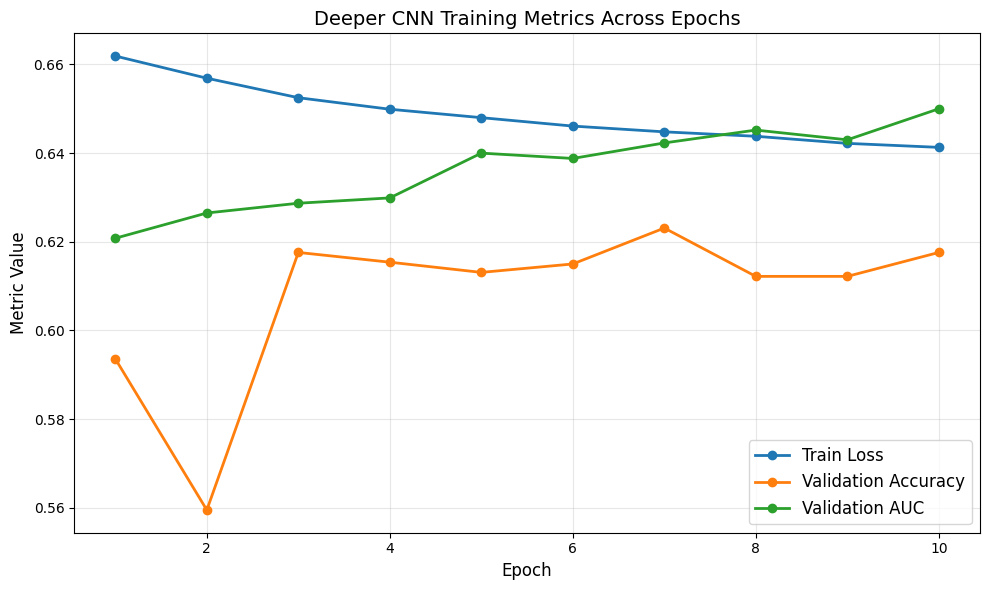

In [5]:
import matplotlib.pyplot as plt

# Data
epochs = range(1, 11)

train_loss = [0.6619, 0.6569, 0.6525, 0.6499, 0.6480, 0.6461, 0.6448, 0.6438, 0.6422, 0.6413]
val_acc =     [0.5936, 0.5595, 0.6176, 0.6154, 0.6131, 0.6150, 0.6231, 0.6122, 0.6122, 0.6176]
val_auc =     [0.6208, 0.6265, 0.6287, 0.6299, 0.6400, 0.6388, 0.6423, 0.6452, 0.6430, 0.6500]

# Plot
plt.figure(figsize=(10, 6))

plt.plot(epochs, train_loss, marker='o', linewidth=2, label="Train Loss")
plt.plot(epochs, val_acc, marker='o', linewidth=2, label="Validation Accuracy")
plt.plot(epochs, val_auc, marker='o', linewidth=2, label="Validation AUC")

plt.title("Deeper CNN Training Metrics Across Epochs", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Metric Value", fontsize=12)

plt.grid(alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()